In [3]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load the NIST dataset
nist = fetch_openml('mnist_784', version=1, parser='auto')
X = np.array(nist.data.astype('float64'))
y = nist.target.astype('int')
# Labeling: +1 for 4, -1 for 9, 2 for 3, -2 for 8, 0 for unknown, +3 for 2, -3 for 7
y_multiclass = np.where(y == 4, 1, np.where(y == 9, -1, np.where(y == 3, 2, np.where(y == 8, -2, np.where(y == 2, 3, np.where(y == 7, -3, 0))))))

# Use a smaller subset of the data for testing
subset_size = 1000  
subset_indices = np.random.choice(len(X), size=subset_size, replace=False)
X_subset = X[subset_indices]
y_multiclass_subset = y_multiclass[subset_indices]

# Step 1: Construct the K-NN Graph for Subset
k = 6  # Number of nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_subset)
distances, indices = nbrs.kneighbors(X_subset)
A = np.zeros((len(X_subset), len(X_subset)))

# Create the adjacency matrix based on k-NN for Subset
for i in range(len(X_subset)):
    for j in indices[i]:
        A[i, j] = 1
        A[j, i] = 1  # Assuming an undirected graph

# Step 2: Define the Known Labels Signal and Diagonal Matrix C for Subset
class_1_label = 1  # +1 for class 1 (number 4)
class_2_label = -1  # -1 for class 2 (number 9)
class_3_label = 2  # +2 for class 3 (number 3)
class_4_label = -2  # -2 for class 4 (number 8)
class_5_label = 3  # +3 for class 5 (number 2)
class_6_label = -3  # -3 for class 6 (number 7)



# Define known labels signal s_known_subset
s_known_subset = np.zeros(len(X_subset))
s_known_subset[y_multiclass_subset == class_1_label] = 1
s_known_subset[y_multiclass_subset == class_2_label] = -1
s_known_subset[y_multiclass_subset == class_3_label] = 2
s_known_subset[y_multiclass_subset == class_4_label] = -2
s_known_subset[y_multiclass_subset == class_5_label] = 3
s_known_subset[y_multiclass_subset == class_6_label] = -3



# Create the diagonal matrix C based on s_known_subset
C_subset = np.diag(s_known_subset)

# Step 3: Compute precomputable matrices M1 and M2 for Subset
I_subset = np.identity(len(A))
M1_subset = np.dot((I_subset - A).T, (I_subset - A))
M2_subset = np.dot(C_subset.T, C_subset)

# Step 4: Find the Optimal Alpha for Subset
alpha_values = np.linspace(20.0, 90.0, 800) 
best_alpha_subset = None
min_error_subset = np.inf

for alpha in alpha_values:
    s_predicted_subset = 2 * alpha * np.linalg.inv(M1_subset + 2 * alpha * M2_subset).dot(M2_subset).dot(s_known_subset)
    error_subset = 0.5 * np.linalg.norm(s_predicted_subset - np.dot(A, s_predicted_subset)) ** 2 + alpha * np.linalg.norm(np.dot(C_subset, s_predicted_subset) - np.dot(C_subset, s_known_subset)) ** 2
    if error_subset < min_error_subset:
        min_error_subset = error_subset
        best_alpha_subset = alpha

# Step 5: Compute the Final Predicted Signal for Subset
s_predicted_subset = 2 * best_alpha_subset * np.linalg.inv(M1_subset + 2 * best_alpha_subset * M2_subset).dot(M2_subset).dot(s_known_subset)

# Classify s(predicted_subset) as per the new class labels
s_predicted_subset_classified = np.where(s_predicted_subset < -2, -3, np.where(s_predicted_subset < -1, -2, np.where(s_predicted_subset < 0, -1, np.where(s_predicted_subset < 1, 1, np.where(s_predicted_subset < 2, 2, 3)))))

# Print s(known) and s(predicted) for Subset
print("s(known) for Subset:")
print(s_known_subset)

print("s(predicted) for Subset:")
print(s_predicted_subset_classified)

s(known) for Subset:
[ 0.  2.  2. -3.  2.  3.  2.  0.  0.  0. -2. -2. -3. -2.  1. -3. -2.  0.
 -3. -3. -2.  0. -3.  3. -2. -1.  0.  0.  0. -3. -3.  0. -1. -2.  1.  0.
  3.  3.  3.  0.  3. -3.  0. -3. -1. -2. -2.  0.  0.  0.  0.  1. -3.  0.
  0.  0. -1.  0.  2.  0.  0. -3. -1.  0. -1.  0. -1.  1. -3.  3.  0.  1.
  2. -2.  0. -1.  0.  0. -1.  1.  0.  2.  0.  0. -3.  0.  0.  0. -2. -2.
 -2.  0. -2.  0.  0.  1. -1.  0. -1.  1.  1.  1.  0.  0.  0.  0. -1.  0.
  0. -1. -2. -1.  3.  0.  0. -3. -1.  0.  0.  2.  0.  0.  0. -3.  0.  3.
  0. -3. -3.  1.  3. -1.  0.  0.  1.  0.  0.  0. -1. -1.  0.  2. -3.  0.
  0.  0.  0.  0. -3.  0.  3. -3.  2. -3. -3.  0.  0.  1. -1.  3. -1. -1.
  0.  3.  0.  0. -2. -2.  0. -3. -1.  3.  2.  2. -2.  2. -1.  0. -3.  2.
  3. -1.  1.  0.  1. -3. -2.  0. -3.  0. -1. -3.  0.  0.  0.  0. -2.  3.
  0.  0.  0.  0.  0.  1. -1.  0.  2.  0.  0.  0.  2.  2. -3.  1.  2.  0.
  2. -1.  0. -2.  1.  1.  1.  0. -2. -1.  0. -3. -3.  0. -2. -2. -3.  1.
  0.  3.  3.  2.  1.  0.  2.  

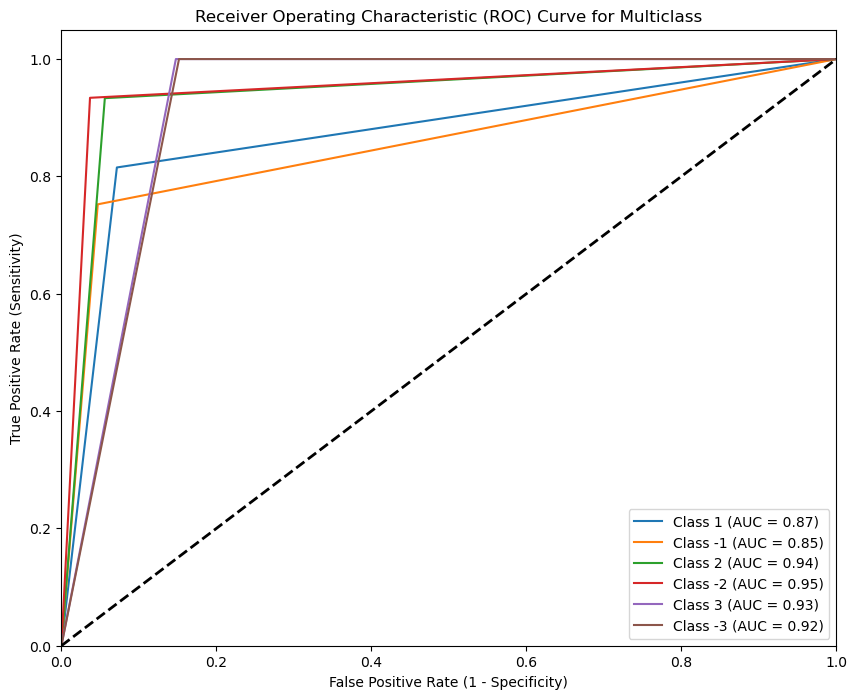

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming s_known_subset and s_predicted_subset are the known and predicted signals for multiclass classification
# Update class_labels accordingly based on your specific labels

# Class labels
class_labels = [1, -1, 2, -2, 3, -3]

# Binarize the labels
y_true_binary = label_binarize(s_known_subset, classes=class_labels)
y_score_binary = label_binarize(s_predicted_subset_classified, classes=class_labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_score_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc="lower right")
plt.show()